In [60]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:teslaV100s:1 ./ctct_dense16.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label,plot_performance, score2
from compass.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd



In [61]:
df_label = pd.read_pickle('PAIRED_PD1_CTLA4_POST_SMPLE.TABLE')
df_tpm = pd.read_pickle('PAIRED_PD1_CTLA4_POST_TPM.TABLE')

In [62]:
# ## Keep only PD1 and CTLA4
# df_label = df_label[(df_label.Therapy.isin(['PD1', 'CTLA4+PD1', 'CTLA4'])) & df_label.cohort.isin(['Riaz', 'Gide' ])] #'Prins_GBM_2019', 'Zhao'
# df_tpm = df_tpm.loc[df_label.index]
len(df_label)

86

In [63]:
from compass.tokenizer import CONCEPT_palette
import shap
import torch
import torch.nn as nn
from shap import DeepExplainer, KernelExplainer
torch.manual_seed(0)

In [64]:
s = df_label.groupby('cohort').size()
cancer_type = '_'.join(df_label.cancer_type.unique())

df_tpm = df_tpm.loc[df_label.index]
dfcx_org = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
df_task = onehot(df_label.response_label)

In [65]:
cohorts = ['All']

#cohorts.extend(df_label.cohort.value_counts().index.tolist())

In [66]:
cancer_name_dict = {}
for cohort in cohorts:
    if cohort == 'All':
        df1 = df_label
    else:
        df1 = df_label[df_label.cohort == cohort]
    cancer_name_dict[cohort] = '%s(n=%s)' % (cohort, len(df1))

In [67]:
seed = 42
### using pre model

In [68]:
save_dir = './results/post'
finetuner = loadcompass(os.path.join(save_dir, 'finetuner_lft_post_PD1_CTLA4_seed_%s.pt' % seed))


In [69]:
for cohort in cohorts:
    if cohort  == 'All':
        idx = df_label.index
    else:
        idx = df_label[df_label.cohort == cohort].index
    dfcx = dfcx_org.loc[idx]

    
    device = finetuner.device
    
    dfg, dfc = finetuner.extract(dfcx, batch_size = 32,)
    _, dfy = finetuner.predict(dfcx, batch_size = 32,)
    
    model = finetuner.model.taskdecoder
    model.eval()
    
    def predict(data):
        model.eval()
        with torch.no_grad():
            data_tensor = torch.tensor(data, dtype=torch.float32)
            return model(data_tensor.to(device)).cpu().numpy()
            
    fname = dfc.columns[:]
    x = torch.tensor(dfc[fname].values).to(device)
    
    K = 150
    background = x.cpu().numpy() if len(x) < K else shap.kmeans(x.cpu().numpy(), k = K).data
    #background = shap.sample(dfc[fname].values,nsamples=50, random_state=42)
    #background = x.cpu().numpy()

    
    #background = dfc[fname].mean().to_frame().T.values #
    #background = torch.zeros((1, len(fname))).to(device).cpu().numpy()

    
    e = KernelExplainer(predict, background)
    shap_values = e.shap_values(x.cpu().numpy(), check_additivity=True)
    
    df1 = pd.DataFrame(shap_values[1], columns = fname, index=dfcx.index)
    df1.to_csv('./results/post/%s_shap_pft_r.csv' % cohort)
    
    df2 = pd.DataFrame(shap_values[0], columns = fname, index=dfcx.index)
    df2.to_csv('./results/post/%s_shap_pft_nr.csv' % cohort)
    
    shap.summary_plot(shap_values, x.cpu().numpy(), feature_names = fname, show=False, 
                      class_names = {0:'NR', 1:'R'},  max_display = 50)
    plt.savefig('./results/post/%s_shap_bar_plot.svg' % cohort, bbox_inches='tight')
    plt.close()
    
    shap.summary_plot(shap_values[1], x.cpu().numpy(), feature_names = fname,
                      cmap='bwr', plot_type='dot', 
                      class_names = {0:'NR', 1:'R'}, show = False,  max_display = 50)
    plt.savefig('./results/post/%s_shap_summary_plot.svg' % cohort, bbox_inches='tight')
    plt.close()

100%|##########| 3/3 [00:00<00:00, 10.47it/s]


  0%|          | 0/86 [00:00<?, ?it/s]

In [70]:
res = []
for cancer in cohorts:
    df1 = pd.read_csv('./results/post/%s_shap_pft_nr.csv' % cancer, index_col=0)
    df2 = pd.read_csv('./results/post/%s_shap_pft_r.csv' % cancer, index_col = 0)    
    
    nr = df1.abs().mean().to_frame(name = 'NR')
    r = df2.abs().mean().to_frame(name = 'R')
    df = nr.join(r)
    df['group'] = cancer

    res.append(df)

In [71]:
dfa = pd.concat(res)
dfa.index.name = 'concept'
data = dfa.reset_index()

data['R/NR_mean'] = data[['R', 'NR']].mean(axis=1)
data['R/NR_std'] = data[['R', 'NR']].std(axis=1)

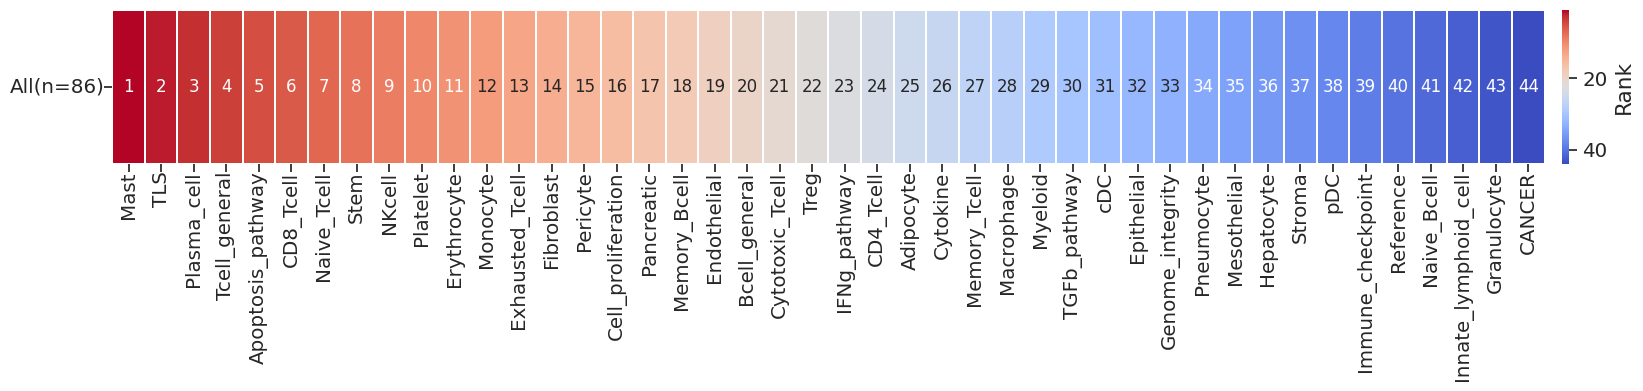

In [72]:
data1 = pd.pivot_table(data, values = 'R/NR_mean', index = 'concept', columns = 'group').rank(axis=0, ascending=False)
order = data1['All'].sort_values(ascending=True).index

data1 = data1.loc[order][cohorts]
fig, ax = plt.subplots(figsize=(22,2))

cols_name = [cancer_name_dict[i] for i in cohorts]


g = sns.heatmap(data1.T, ax=ax, annot=True, annot_kws={'fontsize':12,}, cbar_kws={ "pad": 0.01, 'label':'Rank'}, cmap = 'coolwarm_r', linewidths = 0.005,)
ax.set_ylabel(None)
ax.set_xlabel(None)


ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

ax.set_yticklabels(cols_name, rotation=0)
cbar = g.collections[0].colorbar
cbar.ax.invert_yaxis()

fig.savefig('./results/01_post_top_ranked_concepts.svg', bbox_inches='tight')